### We randomly sample 80% as training and 20% as testing.

We choose three different Y :
1. UNRATE: Civilian Unemployment Rate
2. HOUST: Housing Starts: Total New Privately Owned
3. FEDFUNDS: Effective Federal Funds Rate

In [1]:
import torch
import torch.nn as nn # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F # All functions that don't have any parameters
from torch.autograd import Variable

from sklearn.metrics.pairwise import rbf_kernel
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from quantile_forest import RandomForestQuantileRegressor


import cvxpy as cp
import numpy as np
from numpy import linalg
import pandas as pd

from scipy.linalg import sqrtm


from matplotlib import pyplot as plt

import seaborn as sns
import matplotlib.patches as patches
import matplotlib.lines as lines

In [2]:
# Possible estimators

# 1-layer NN
class NN1(nn.Module):
    def __init__(self, input_size, output_size):
        super(NN1, self).__init__()
        self.fc1 = nn.Linear(input_size, 10)
        self.fc2 = nn.Linear(10, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
# 2-layer NN
class NN2(nn.Module):
    def __init__(self, input_size, output_size):
        super(NN2, self).__init__()
        self.fc1 = nn.Linear(input_size, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x 
    
# Random Forest
# model setup: rf = RandomForestRegressor(n_estimators = 500, random_state = 18)
# training RF: rf.fit(X_pre, Y_pre)
# predict with RF: prediction = rf.predict(X_t)

# XGBoost
# model setup: xgb = XGBRegressor(n_estimators=300,random_state=0)
# training XGBoost: xgb.fit(X_pre,Y_pre)
#prediction with XGBoost: xgb.predict(X_t)


In [3]:
# RKHS estimate mean with regularization
def mean_RKHS(K, Y):
    n = K.shape[0]
    a = cp.Variable(n)
    sqrt_K = sqrtm(K)
    constraints = []
    prob = cp.Problem(cp.Minimize(cp.sum_squares(Y-K@a)+cp.sum_squares(sqrt_K@a)), constraints)
    prob.solve()
    return a.value

In [4]:
# train mean estimator that estimate E[Y|X]
def mean_est(est_type,X_pre,Y_pre,X_opt,X_adj,X_t):
    
    """
        est_type: 
        "NN1": 1-layer NN;    "NN2": 2-layer NN;    "rf": random forest; 
        "gb": gradient boosting;      "lin": linear regression;    "poly2": polynomial with degree 2;
        "rkhs_poly2": RKHS with polynomial kernel (degree=2);      "rkhs_rbf": RKHS with RBF kernel
    
        (X_pre,Y_pre): training data
        X_opt,X_adj,X_t: data used to predict
        output: mean estimator m and the predictions m(X)
    """

    if est_type == "NN1":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = NN1(input_size=1, output_size=1).to(device)
        criterion=nn.MSELoss()
        learning_rate = 0.001
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        for epoch in range(1000):
            #convert numpy array to torch Variable
            inputs=Variable(torch.from_numpy(X_pre))
            labels=Variable(torch.from_numpy(Y_pre))
            
            #clear gradients wrt parameters
            optimizer.zero_grad()
    
            #Forward to get outputs
            outputs=model(inputs.float())
    
            #calculate loss
            loss=criterion(outputs.float(), labels.float())
    
            #getting gradients wrt parameters
            loss.backward()
    
            #updating parameters
            optimizer.step()
        M_opt = model(torch.from_numpy(X_opt).float())
        M_opt = M_opt.detach().cpu().numpy().reshape(-1,1)
        M_adj = model(torch.from_numpy(X_adj).float())
        M_adj = M_adj.detach().cpu().numpy().reshape(-1,1)
        M_t = model(torch.from_numpy(X_t).float())
        M_t = M_t.detach().cpu().numpy().reshape(-1,1)
        return model, M_opt, M_adj, M_t
    if est_type == "NN2":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = NN2(input_size=1, output_size=1).to(device)
        criterion=nn.MSELoss()
        learning_rate = 0.001
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        for epoch in range(1000):
            #convert numpy array to torch Variable
            inputs=Variable(torch.from_numpy(X_pre))
            labels=Variable(torch.from_numpy(Y_pre))
    
            #clear gradients wrt parameters
            optimizer.zero_grad()
    
            #Forward to get outputs
            outputs=model(inputs.float())
    
            #calculate loss
            loss=criterion(outputs.float(), labels.float())
    
            #getting gradients wrt parameters
            loss.backward()
    
            #updating parameters
            optimizer.step()
        M_opt = model(torch.from_numpy(X_opt).float())
        M_opt = M_opt.detach().cpu().numpy().reshape(-1,1)
        M_adj = model(torch.from_numpy(X_adj).float())
        M_adj = M_adj.detach().cpu().numpy().reshape(-1,1)
        M_t = model(torch.from_numpy(X_t).float())
        M_t = M_t.detach().cpu().numpy().reshape(-1,1)
        return model, M_opt, M_adj, M_t
    
    if est_type == "rf":
        model = RandomForestRegressor(n_estimators = 500, random_state = 0,criterion='squared_error')
        model.fit(X_pre, Y_pre)
        M_opt = model.predict(X_opt).reshape(-1,1)
        M_adj = model.predict(X_adj).reshape(-1,1)
        M_t = model.predict(X_t).reshape(-1,1)
        return model, M_opt, M_adj, M_t
    
    if est_type == "gb":
        model = GradientBoostingRegressor(n_estimators=300,random_state=0,loss = "squared_error")
        model.fit(X_pre, Y_pre)
        M_opt = model.predict(X_opt).reshape(-1,1)
        M_adj = model.predict(X_adj).reshape(-1,1)
        M_t = model.predict(X_t).reshape(-1,1)
        return model, M_opt, M_adj, M_t
    
    if est_type == "lin":
        model = LinearRegression()
        model.fit(X_pre,Y_pre)
        M_opt = model.predict(X_opt).reshape(-1,1)
        M_adj = model.predict(X_adj).reshape(-1,1)
        M_t = model.predict(X_t).reshape(-1,1)
        return model, M_opt, M_adj, M_t
    
    if est_type == "poly2":
        model = LinearRegression()
        poly_regr = PolynomialFeatures(degree=2, include_bias=False)
        X_pre_poly = poly_regr.fit_transform(X_pre) 
        model.fit(X_pre_poly, Y_pre)
        X_opt_poly = poly_regr.fit_transform(X_opt)
        X_adj_poly = poly_regr.fit_transform(X_adj) 
        X_t_poly = poly_regr.fit_transform(X_t)
        M_opt = model.predict(X_opt_poly).reshape(-1,1)
        M_adj = model.predict(X_adj_poly).reshape(-1,1)
        M_t = model.predict(X_t_poly).reshape(-1,1)
        return model, M_opt, M_adj, M_t
    
    if est_type == "poly3":
        model = LinearRegression()
        poly_regr = PolynomialFeatures(degree=3, include_bias=False)
        X_pre_poly = poly_regr.fit_transform(X_pre) 
        model.fit(X_pre_poly, Y_pre)
        X_opt_poly = poly_regr.fit_transform(X_opt)
        X_adj_poly = poly_regr.fit_transform(X_adj) 
        X_t_poly = poly_regr.fit_transform(X_t)
        M_opt = model.predict(X_opt_poly).reshape(-1,1)
        M_adj = model.predict(X_adj_poly).reshape(-1,1)
        M_t = model.predict(X_t_poly).reshape(-1,1)
        return model, M_opt, M_adj, M_t
    
    if est_type == "rkhs_poly1":
        degree = 1
        X_inner_prod = X_pre @ X_pre.T
        K = np.power(1 + X_inner_prod, degree)
        a = mean_RKHS(K,Y_pre[:,0])
        
        X_inner_prod_opt = X_opt @ X_pre.T
        K_opt = np.power(1 + X_inner_prod_opt, degree)
        M_opt = K_opt@a
        M_opt = M_opt.reshape(-1,1)
        
        X_inner_prod_adj = X_adj @ X_pre.T
        K_adj = np.power(1 + X_inner_prod_adj, degree)
        M_adj = K_adj@a
        M_adj = M_adj.reshape(-1,1)
        
        X_inner_prod_t = X_t @ X_pre.T
        K_t = np.power(1 + X_inner_prod_t, degree)
        M_t = K_t@a
        M_t = M_t.reshape(-1,1)
        return a, M_opt, M_adj, M_t
    
    if est_type == "rkhs_rbf":
        sigma = 1
        K = rbf_kernel(X_pre, gamma = 1/(2*sigma**2))
        a = mean_RKHS(K,Y_pre[:,0])
        
        K_opt = rbf_kernel(X_opt, X_pre, gamma = 1/(2*sigma**2))
        M_opt = K_opt@a
        M_opt = M_opt.reshape(-1,1)
        
        K_adj = rbf_kernel(X_adj, X_pre, gamma = 1/(2*sigma**2))
        M_adj = K_adj@a
        M_adj = M_adj.reshape(-1,1)
        
        K_t = rbf_kernel(X_t, X_pre, gamma = 1/(2*sigma**2))
        M_t = K_t@a
        M_t = M_t.reshape(-1,1)
        return a, M_opt, M_adj, M_t

In [5]:
# train quantile estimator that estimate quantile for Y|X

# quantile loss for NN
def quantile_loss(preds, target, quantile):
    assert not target.requires_grad
    assert preds.size(0) == target.size(0)
    errors = target - preds
    q = quantile
    losses = torch.max((q - 1) * errors, q * errors)
    loss = torch.sum(losses)
    return loss

def est_quantile(est_type,quantile,X_pre,Y_pre,X_opt,X_adj,X_t):
    """
        est_type: 
        "NN1": 1-layer NN;              "NN2": 2-layer NN; 
        "qrf": quantile regression forest;    "gb": gradient boosting
        
        quantile: the quantile we are estimating
        (X_pre,Y_pre): training data
        X_opt,X_adj,X_t: data used to predict
        output: quantile estimator Q and the prediction Q(X) 
    """
    
    if est_type == "NN1":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = NN1(input_size=1, output_size=1).to(device)
        learning_rate = 0.001
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        for epoch in range(1000):
            #convert numpy array to torch Variable
            inputs=Variable(torch.from_numpy(X_pre))
            labels=Variable(torch.from_numpy(Y_pre))
        
            #clear gradients wrt parameters
            optimizer.zero_grad()
    
            #Forward to get outputs
            outputs=model(inputs.float())
    
            #calculate loss
            loss=quantile_loss(outputs, labels, quantile)
    
            #getting gradients wrt parameters
            loss.backward()
    
            #updating parameters
            optimizer.step()
        Q_opt = model(torch.from_numpy(X_opt).float())
        Q_opt = Q_opt.detach().cpu().numpy().reshape(-1,1)
        Q_adj = model(torch.from_numpy(X_adj).float())
        Q_adj = Q_adj.detach().cpu().numpy().reshape(-1,1)
        Q_t = model(torch.from_numpy(X_t).float())
        Q_t = Q_t.detach().cpu().numpy().reshape(-1,1)
        return model, Q_opt, Q_adj, Q_t
    
    if est_type == "NN2":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = NN2(input_size=1, output_size=1).to(device)
        learning_rate = 0.001
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        for epoch in range(1000):
            #convert numpy array to torch Variable
            inputs=Variable(torch.from_numpy(X_pre))
            labels=Variable(torch.from_numpy(Y_pre))
        
            #clear gradients wrt parameters
            optimizer.zero_grad()
    
            #Forward to get outputs
            outputs=model(inputs.float())
    
            #calculate loss
            loss=quantile_loss(outputs, labels, quantile)
    
            #getting gradients wrt parameters
            loss.backward()
    
            #updating parameters
            optimizer.step()
        Q_opt = model(torch.from_numpy(X_opt).float())
        Q_opt = Q_opt.detach().cpu().numpy().reshape(-1,1)
        Q_adj = model(torch.from_numpy(X_adj).float())
        Q_adj = Q_adj.detach().cpu().numpy().reshape(-1,1)
        Q_t = model(torch.from_numpy(X_t).float())
        Q_t = Q_t.detach().cpu().numpy().reshape(-1,1)
        return model, Q_opt, Q_adj, Q_t
    
    if est_type == "qrf":
        model = RandomForestQuantileRegressor(n_estimators = 500, random_state = 0)
        model.fit(X_pre, Y_pre)
        Q_opt = model.predict(X_opt,quantiles = [quantile]).reshape(-1,1)
        Q_adj = model.predict(X_adj,quantiles = [quantile]).reshape(-1,1)
        Q_t = model.predict(X_t,quantiles = [quantile]).reshape(-1,1)
        return model, Q_opt, Q_adj, Q_t
    
    
    if est_type == "gb":
        model = GradientBoostingRegressor(n_estimators=300,random_state=0,loss = "quantile", alpha = quantile)
        model.fit(X_pre, Y_pre)
        Q_opt = model.predict(X_opt).reshape(-1,1)
        Q_adj = model.predict(X_adj).reshape(-1,1)
        Q_t = model.predict(X_t).reshape(-1,1)
        return model, Q_opt, Q_adj, Q_t

In [6]:
# solve RKHS optimization problem
def RKHS_opt(K, Y):
    n = K.shape[0]
    hB = cp.Variable((n, n), symmetric=True)
    constraints = [hB >> 0]
    constraints += [K[i, :] @ hB @ K[i, :] >= cp.square(Y[i]) for i in range(n)]
    prob = cp.Problem(cp.Minimize(cp.trace(K @ hB @ K.T)), constraints)
    prob.solve()
    return hB.value

In [7]:
# Solving the optimization problem
def solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t,
              function_class, E_opt=None, E_adj=None, E_t=None, degree = None,sigma = None):
    """
        M_opt: mean estimator m(X_opt)
        
        function_class: 
        "aug": Augmentation, "rkhs_poly": RKHS with polynomial kernel, "rkhs_rbf": RKHS with RBF kernel
        
        E_opt: if function_class = "aug", then E is the estimator matrix, i.e. (E_opt)_{ij} = f_i((X_opt)_j)
        degree: if function_class = "rkhs_poly", then set the degree of the polynomial
        sigma: if function_class = "rkhs_rbf", then set parameter sigma
        
        (X_opt,Y_opt): data used to solve the optimization problem
        output: estimator for 100% coverage V_adj and V_t, optimal solution
    """
    n_opt = X_opt.shape[0]
    n_adj = X_adj.shape[0]
    n_t = X_t.shape[0]
    Y = (Y_opt-M_opt)[:,0]
        
    if function_class == "aug":
        cons_opt = np.ones(n_opt).reshape(1,-1)
        A_opt = np.vstack((E_opt,cons_opt))
        weight = cp.Variable(A_opt.shape[0])
        constraints = [weight>=0]+[weight @ A_opt >= cp.square(Y)]
        prob = cp.Problem(cp.Minimize(cp.sum(weight @ A_opt)), constraints)
        prob.solve()
        optimal_weight = weight.value
        
        cons_adj = np.ones(n_adj).reshape(1,-1)
        A_adj = np.vstack((E_adj,cons_adj))
        V_adj = optimal_weight @ A_adj
        V_adj = V_adj.reshape(-1,1)
        
        cons_t = np.ones(n_t).reshape(1,-1)
        A_t = np.vstack((E_t,cons_t))
        V_t = optimal_weight @ A_t
        V_t = V_t.reshape(-1,1)
        return V_adj, V_t, optimal_weight
    
    if function_class == "rkhs_poly":
        X_inner_prod = X_opt @ X_opt.T
        K = np.power(1 + X_inner_prod, degree)
        hB = RKHS_opt(K,Y)
        
        X_inner_prod_adj = X_adj @ X_opt.T
        K_adj = np.power(1 + X_inner_prod_adj, degree)
        V_adj = np.diag(K_adj @ hB @ K_adj.T)
        V_adj = V_adj.reshape(-1,1)
        
        X_inner_prod_t = X_t @ X_opt.T
        K_t = np.power(1 + X_inner_prod_t, degree)
        V_t = np.diag(K_t @ hB @ K_t.T)
        V_t = V_t.reshape(-1,1)
        return V_adj, V_t, hB
    
    if function_class == "rkhs_rbf":
        K_opt = rbf_kernel(X_opt, gamma = 1/(2*sigma**2))
        hB = RKHS_opt(K_opt,Y)
        
        K_adj = rbf_kernel(X_adj, X_opt, gamma = 1/(2*sigma**2))
        V_adj = np.diag(K_adj @ hB @ K_adj.T)
        V_adj = V_adj.reshape(-1,1)
        
        K_t = rbf_kernel(X_t, X_opt, gamma = 1/(2*sigma**2))
        V_t = np.diag(K_t @ hB @ K_t.T)
        V_t = V_t.reshape(-1,1)
        return V_adj, V_t, hB
    

In [8]:
# Interval adjustment
def interval_adj(X_adj,Y_adj,M_adj,V_adj,alpha, stepsize=0.01,eps=0):
    """
        (X_adj,Y_adj): data used to adjust the interval
         M_adj: mean estimator m(X_adj)
         V_adj: variance estimator for 100% coverage f(X_adj)
         alpha: get 1-alpha coverage
         eps: extend the interval a bit 1/sqrt{log(n_opt)}
         output: adjustment level delta
         the prediction level is: [M-sqrt{delta V}, M+sqrt{delta V}]
    """
    I = np.where(V_adj+eps-np.square(Y_adj-M_adj)>=0)[0]
    I.tolist()
    Y_adj = Y_adj[I].reshape(-1,1)
    M_adj = M_adj[I].reshape(-1,1)
    V_adj = (V_adj[I]+eps).reshape(-1,1)
    delta = 1
    prop_outside = (np.power(Y_adj[:,0]-M_adj[:,0], 2) > delta * V_adj[:,0]).mean()
    while prop_outside <= alpha:
        delta = delta-stepsize
        prop_outside = (np.power(Y_adj[:,0]-M_adj[:,0], 2) > delta * V_adj[:,0]).mean()
    return delta

In [9]:
# Plot the results
def my_plot(X_t,Y_t,M_t,V_t,X_axis="X", Y_axis="Y"):
    """
        (X_t,Y_t): test data
         M_t: mean estimator m(X_t)
         V_t: variance estimator f(X_t)
         The prediction interval is [M_t-sqrt{V_t},M+sqrt{V_t}]
         
         X_axis: name for the X axis
         Y_axis: name for the Y axis
    
    """
    
    X_sort = np.sort(X_t, axis=0)
    X_sort_indices = np.argsort(X_t, axis=0)
    Y_sort = Y_t[X_sort_indices[:, 0]]
    lower_CI = M_t-np.sqrt(V_t)
    lower_CI_sort = lower_CI[X_sort_indices[:, 0]]
    upper_CI = M_t+np.sqrt(V_t)
    upper_CI_sort = upper_CI[X_sort_indices[:, 0]]
    mean = M_t[X_sort_indices[:, 0]]
    
    sns.set()
    sns.set_style("darkgrid")
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
    palette = sns.color_palette("Blues_r", 4)
    sns.scatterplot(x=X_sort[:,0], y=Y_sort[:,0], color=palette[0], edgecolor='w', linewidth=0.5)
    plt.fill_between(X_sort[:,0], lower_CI_sort[:,0], upper_CI_sort[:,0], color=palette[1], alpha=0.4)
    plt.plot(X_sort, lower_CI_sort, color=palette[2], lw=2,alpha=0.6)
    plt.plot(X_sort, upper_CI_sort, color=palette[2], lw=2,alpha=0.6)
    plt.plot(X_sort, mean, '-', color='orange', linewidth=2,label="Mean")
#    plt.plot(X_sort, mean, color=palette[3], linewidth=2, label="Mean")
    plt.xlabel(X_axis)
    plt.ylabel(Y_axis)
    plt.ylim(-3,3)
    legend_elements = [
    patches.Rectangle((0, 0), 1, 1, lw=0, color=palette[1], alpha=0.4, label="PI"),
    lines.Line2D([0], [0], color='orange', lw=2, label="Mean")]
    plt.legend(handles=legend_elements, loc='upper right')
#     plt.legend(loc='upper right')
    plt.show()
    # plt.savefig("plot.png", dpi=300)
    coverage = (np.power(Y_t[:,0]-M_t[:,0], 2) <= V_t[:,0]).mean()
    bandwidth = np.mean(V_t[:,0])
    print("The overall coverage is", coverage)
    print("The mean bandwidth for testing data is", bandwidth)

In [10]:
# Plot the mean M and Y
def my_plot2(X_t,Y_t,M_t,V_t,X_axis="X",Y_axis="Y"):
    """
        (X_t,Y_t): test data
         M_t: mean estimator m(X_t)
         V_t: variance estimator f(X_t)
         The prediction interval is [M_t-sqrt{V_t},M+sqrt{V_t}]
    """
    X_plot = M_t
    X_sort = np.sort(X_plot, axis=0)
    X_sort_indices = np.argsort(X_plot, axis=0)
    Y_sort = Y_t[X_sort_indices[:, 0]]
    lower_CI = M_t-np.sqrt(V_t)
    lower_CI_sort = lower_CI[X_sort_indices[:, 0]]
    upper_CI = M_t+np.sqrt(V_t)
    upper_CI_sort = upper_CI[X_sort_indices[:, 0]]
    mean = M_t[X_sort_indices[:, 0]]
        
    sns.set()
    sns.set_style("darkgrid")
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
    palette = sns.color_palette("Blues_r", 4)
    sns.scatterplot(x=X_sort[:,0], y=Y_sort[:,0], color=palette[0], edgecolor='w', linewidth=0.5)
    plt.fill_between(X_sort[:,0], lower_CI_sort[:,0], upper_CI_sort[:,0], color=palette[1], alpha=0.4)
    plt.plot(X_sort, lower_CI_sort, color=palette[2], lw=2,alpha=0.6)
    plt.plot(X_sort, upper_CI_sort, color=palette[2], lw=2,alpha=0.6)
    plt.plot(X_sort, mean, '-', color='orange', linewidth=2,label="Mean")
#    plt.plot(X_sort, mean, color=palette[3], linewidth=2, label="Mean")
    plt.xlabel(X_axis)
    plt.ylabel(Y_axis)
    legend_elements = [
    patches.Rectangle((0, 0), 1, 1, lw=0, color=palette[1], alpha=0.4, label="PI"),
    lines.Line2D([0], [0], color='orange', lw=2, label="Mean")]
    plt.legend(handles=legend_elements, loc='upper right')
#     plt.legend(loc='upper right')
    plt.show()
    # plt.savefig("plot.png", dpi=300)
    coverage = (np.power(Y_t[:,0]-M_t[:,0], 2) <= V_t[:,0]).mean()
    bandwidth = np.mean(V_t[:,0])
    print("The overall coverage is", coverage)
    print("The mean bandwidth for testing data is", bandwidth)

In [11]:
# Plot Y
def my_plot3(X_t,Y_t,M_t,V_t,Y_axis="Y"):
    """
        (X_t,Y_t): test data
         M_t: mean estimator m(X_t)
         V_t: variance estimator f(X_t)
         The prediction interval is [M_t-sqrt{V_t},M+sqrt{V_t}]
    """
    lower_CI = M_t-np.sqrt(V_t)
    upper_CI = M_t+np.sqrt(V_t)
    mean = M_t
    x_axis = range(Y_t.shape[0])
    
    sns.set()
    sns.set_style("darkgrid")
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
    palette = sns.color_palette("Blues_r", 4)
    sns.scatterplot(x_axis,y=Y_t[:,0], color=palette[0], edgecolor='w', linewidth=0.5)
    plt.fill_between(x_axis, lower_CI[:,0], upper_CI[:,0], color=palette[1], alpha=0.4)
    plt.plot(x_axis, lower_CI, color=palette[2], lw=2,alpha=0.6)
    plt.plot(x_axis, upper_CI, color=palette[2], lw=2,alpha=0.6)
    plt.plot(x_axis, mean, '-', color='orange', linewidth=2,label="Mean")
#    plt.plot(X_sort, mean, color=palette[3], linewidth=2, label="Mean")
#    plt.xlabel("X")
    plt.ylabel(Y_axis)
    legend_elements = [
    patches.Rectangle((0, 0), 1, 1, lw=0, color=palette[1], alpha=0.4, label="PI"),
    lines.Line2D([0], [0], color='orange', lw=2, label="Mean")]
    plt.legend(handles=legend_elements, loc='upper right')
#     plt.legend(loc='upper right')
    plt.show()
    # plt.savefig("plot.png", dpi=300)
#     coverage = (np.power(Y_t[:,0]-M_t[:,0], 2) <= V_t[:,0]).mean()
#     bandwidth = np.mean(V_t[:,0])
#     print("The overall coverage is", coverage)
#     print("The mean bandwidth for testing data is", bandwidth)

In [12]:
# read the data
X = pd.read_csv('X_pca_top1.CSV')
X = X.to_numpy()[:,1].reshape(-1,1)
Y = pd.read_csv('Scaled_values_of_Y.CSV')
Y = Y.to_numpy()[:,1:4]


# We use X to predict Y 
Y_axis = "UNRATE"
Y = Y[:,0].reshape(-1,1)


# Remove outliers (w.r.t Y ) using IQR
Data = np.hstack([X,Y])
Q1 = np.percentile(Y, 25, interpolation = 'midpoint')
 
Q3 = np.percentile(Y, 75, interpolation = 'midpoint')
IQR = Q3 - Q1
upper=Q3+1.5*IQR
upper_array=np.array(Y<=upper)
lower=Q1-1.5*IQR
lower_array=np.array(Y>=lower)
index_keep = upper_array & lower_array
Data = Data[index_keep[:,0].tolist(),:]

print("The number of data being removed is ", Y.shape[0]-Data.shape[0])


# # split the data into training and testing
# from sklearn.model_selection import train_test_split
# training_data, testing_data = train_test_split(Data, test_size=0.4, random_state=25)

# X_train = training_data[:,0:3]
# Y_train = training_data[:,3].reshape(-1,1)
# X_t = testing_data[:,0:3]
# Y_t = testing_data[:,3].reshape(-1,1)


# # Plot the data w.r.t each component of X
# plt.figure(figsize=(20,5))
# for i in range(3):
#     plt.subplot(1,3,i+1)
#     plt.plot(X_train[:,i],Y_train,'o',color = 'orange',label = 'training data')
#     plt.plot(X_t[:,i],Y_t,'.', label = 'testing data')
#     plt.xlabel('%d-th component of X' % (i+1))
#     plt.ylabel('Y')
#     plt.legend(loc="upper right")
# plt.tight_layout()
# plt.show()


# # pre-training data, opt data, adj data
# n1 = round(0.1*X_train.shape[0])
# n2 = round(0.4*X_train.shape[0])
# X_pre = X_train[0:n1,:]
# Y_pre = Y_train[0:n1,:]
# # X_opt = X_train[n1:,:]
# # Y_opt = Y_train[n1:,:]
# # X_adj = np.zeros((1,3))
# # Y_adj = np.zeros(1).reshape(-1,1)
# X_opt = X_train[n1:n2,:]
# Y_opt = Y_train[n1:n2,:]
# X_adj = X_train[n2:,:]
# Y_adj = Y_train[n2:,:]

np.random.shuffle(Data)
pre_idx = int(Data.shape[0] * 0.6)
opt_idx = int(Data.shape[0] * 0.7)
adj_idx = int(Data.shape[0] * 0.8)
pre_data, opt_data, adj_data, test_data = np.split(Data, [pre_idx, opt_idx, adj_idx])
X_pre = pre_data[:,0].reshape(-1,1)
Y_pre = pre_data[:,1].reshape(-1,1)
X_opt = opt_data[:,0].reshape(-1,1)
Y_opt = opt_data[:,1].reshape(-1,1)
X_adj = adj_data[:,0].reshape(-1,1)
Y_adj = adj_data[:,1].reshape(-1,1)
X_t = test_data[:,0].reshape(-1,1)
Y_t = test_data[:,1].reshape(-1,1)

n_pre = len(X_pre)
n_opt = len(X_opt)
n_adj = len(X_adj)
n_t = len(X_t)

The number of data being removed is  8


<ipython-input-12-6d9ae9e68be1>:15: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q1 = np.percentile(Y, 25, interpolation = 'midpoint')
<ipython-input-12-6d9ae9e68be1>:17: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  Q3 = np.percentile(Y, 75, interpolation = 'midpoint')


/Users/jiawei/opt/anaconda3/lib/python3.8/site-packages/quantile_forest/_quantile_forest.py:104: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  super(BaseForestQuantileRegressor, self).fit(X, y, sample_weight=sample_weight)
/Users/jiawei/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jiawei/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


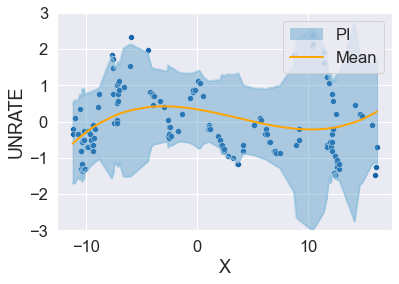

The overall coverage is 0.9463087248322147
The mean bandwidth for testing data is 1.8435933357286634


In [19]:
# Obtain mean estimator
known_mean = "False"
if known_mean == "True":
    M_opt = np.zeros(n_opt).reshape(-1,1)
    M_adj = np.zeros(n_adj).reshape(-1,1)
    M_t = np.zeros(n_t).reshape(-1,1)
else:
    est_type = "poly3"
    model, M_opt, M_adj, M_t = mean_est(est_type,X_pre,Y_pre,X_opt,X_adj,X_t)
    
# Obtain quantile estimators
quantile = [0.8,0.85,0.9,0.95]
m1,Q1_opt,Q1_adj,Q1_t = est_quantile("NN1",quantile[0],X_pre,Y_pre,X_opt,X_adj,X_t)
m2,Q2_opt,Q2_adj,Q2_t = est_quantile("NN2",quantile[1],X_pre,Y_pre,X_opt,X_adj,X_t)
m3,Q3_opt,Q3_adj,Q3_t = est_quantile("qrf",quantile[2],X_pre,Y_pre,X_opt,X_adj,X_t)
m4,Q4_opt,Q4_adj,Q4_t = est_quantile("gb",quantile[3],X_pre,Y_pre,X_opt,X_adj,X_t)

# construct estimator matrix
E_opt = np.hstack(((Q1_opt-M_opt)**2, (Q2_opt-M_opt)**2, (Q3_opt-M_opt)**2, (Q4_opt-M_opt)**2))
E_opt = E_opt.T
E_adj = np.hstack(((Q1_adj-M_adj)**2, (Q2_adj-M_adj)**2, (Q3_adj-M_adj)**2, (Q4_adj-M_adj)**2))
E_adj = E_adj.T
E_t = np.hstack(((Q1_t-M_t)**2, (Q2_t-M_t)**2, (Q3_t-M_t)**2, (Q4_t-M_t)**2))
E_t = E_t.T

# solve optimization problem

V100_adj, V100_t, opt_sol = solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "aug", E_opt, E_adj, E_t)
#V100_adj, V100_t, opt_sol = solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "rkhs_poly", degree = 2)
#V100_adj, V100_t, opt_sol = solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "rkhs_rbf", sigma = 1)

# adjust interval
alpha = 0.05
delta = interval_adj(X_adj,Y_adj,M_adj,V100_adj,alpha)

# plot
V_alpha_t = delta*V100_t
my_plot(X_t,Y_t,M_t,V_alpha_t,X_axis = "X", Y_axis = Y_axis)
# my_plot2(X_t,Y_t,M_t,V_alpha_t,X_axis = "Estimated mean value", Y_axis = Y_axis)
# my_plot3(X_t,Y_t,M_t,V_alpha_t,Y_axis = Y_axis)